In [69]:
import keras
import time
import datetime
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

In [2]:
# 1. Leitura dos Dados
data = pd.read_csv('total_data.csv')
data = data[["zipcode", "property_type", "room_type", "accommodates", "amenities", "bathrooms", "bedrooms", "beds", "bed_type", "price", "minimum_nights", "availability_30", "number_of_reviews", "review_scores_rating", "calculated_host_listings_count"]]

# 1.1 Detecção de colunas com NaN
for col in data.columns:
    print (col + ', Num de valores NaN:', len(data[col][data[col].isnull()]))

C:\Users\first\AppData\Local\Temp\ipykernel_19784\420986748.py:2: DtypeWarning: Columns (1,17,19,20,28,33,34,54,62,63,66,68,69,88) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('total_data.csv')


zipcode, Num de valores NaN: 40634
property_type, Num de valores NaN: 1
room_type, Num de valores NaN: 1
accommodates, Num de valores NaN: 1
amenities, Num de valores NaN: 1
bathrooms, Num de valores NaN: 1494
bedrooms, Num de valores NaN: 776
beds, Num de valores NaN: 2335
bed_type, Num de valores NaN: 1
price, Num de valores NaN: 1
minimum_nights, Num de valores NaN: 1
availability_30, Num de valores NaN: 1
number_of_reviews, Num de valores NaN: 1
review_scores_rating, Num de valores NaN: 384939
calculated_host_listings_count, Num de valores NaN: 2


In [3]:
# 2. Limpeza e Encoding
le = LabelEncoder()
data = data.dropna(how='any', subset=['zipcode', 'property_type', 'room_type', 'accommodates', 'amenities', 'bedrooms', 'beds', 'bathrooms', 'bed_type', 'price', 'minimum_nights',
                                      'availability_30', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count'])
data['room_type_encoded'] = le.fit_transform(data['room_type'])
data['property_type_encoded'] = le.fit_transform(data['property_type'])
data['bed_type_encoded'] = le.fit_transform(data['bed_type'])
data['price'] = data['price'].replace('[\$,]', '', regex=True)
data['price'] = data['price'].astype(float)
data['minimum_nights'] = data['minimum_nights'].astype(int);

# Remove os valores zerados
data = data[data['accommodates'] != 0]
data = data[data['bedrooms'] != 0]
data = data[data['beds'] != 0]
data = data[data['price'] != 0.00]

# Remove os outliers de alguns campos
data['zipcode'] = data['zipcode'].str.replace(r'-\d+', '')
data['zipcode_encoded'] = le.fit_transform(data['zipcode'])
data.drop(data[data['minimum_nights'] > 30].index, axis=0, inplace=True)
data.drop(data[data['minimum_nights'] < 1].index, axis=0, inplace=True)
data.drop(data[data["calculated_host_listings_count"] < 1].index, axis=0, inplace=True)

In [4]:
# 2.1 Encoding das Comodidades
# Transforma as comodidades em um dataframe relacionado com o preço das listagens
amenities = (data['amenities'].str.strip('{}').str.get_dummies(',').rename(columns= lambda x: x.strip('"')))
dataAmenities = pd.DataFrame(data['price']).join(amenities)

In [5]:
# 2.2 Matriz de Correlação -> Coeficientes
# Converte a matrix de correlação criada usando o dataframe em coeficientes lineares
corr = dataAmenities.corr()
attrPriceCoeffs = corr['price'].drop('price')
attrPriceCoeffsVal = attrPriceCoeffs.values.reshape(-1, 1)
scaler = MinMaxScaler()
attrPriceCoeffsNorm = scaler.fit_transform(attrPriceCoeffsVal)

In [6]:
# 2.3 Coeficientes escalares -> somatória ponderada das comodidades
coeffs = pd.DataFrame(attrPriceCoeffsNorm)
coeffs.set_index(attrPriceCoeffs.keys(), inplace=True)
coeffs.rename(columns= lambda  x: 'price', inplace=True)
coeffs.rename(str.lower, axis='index', inplace=True)
dataAmenities.rename(columns= lambda x: x.lower(), inplace=True)
dataAmenities = dataAmenities.drop('price', axis=1)

# Faz a somatória dos valores do dataframe multiplicado pelos coeficientes
dataAmenities['sum'] = (dataAmenities * coeffs['price']).sum(1)
data['amenities_sum'] = dataAmenities['sum']

data

,zipcode,property_type,room_type,accommodates,amenities,bathrooms,bedrooms,beds,bed_type,price,minimum_nights,availability_30,number_of_reviews,review_scores_rating,calculated_host_listings_count,room_type_encoded,property_type_encoded,bed_type_encoded,zipcode_encoded,amenities_sum
0,22020-050,Condominium,Entire home/apt,5,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1.0,2.0,2.0,Real Bed,307.0,4,0.0,213.0,93.0,1.0,0,12,4,1180,11.544701
1,22411-010,Apartment,Entire home/apt,2,"{TV,""Cable TV"",Wifi,""Air conditioning"",""First ...",1.0,1.0,1.0,Real Bed,233.0,3,0.0,85.0,95.0,1.0,0,1,4,1920,6.938440
2,22060-020,Apartment,Entire home/apt,3,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1.0,1.0,2.0,Real Bed,159.0,4,11.0,214.0,94.0,3.0,0,1,4,1347,8.252369
3,22410-003,Apartment,Entire home/apt,3,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1.0,1.0,2.0,Real Bed,253.0,2,0.0,215.0,96.0,1.0,0,1,4,1895,8.518424
4,22081-020,Apartment,Entire home/apt,3,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1.5,1.0,2.0,Real Bed,350.0,2,8.0,122.0,94.0,1.0,0,1,4,1443,12.437025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783759,20230-180,Apartment,Entire home/apt,2,"{TV,Wifi,""Air conditioning"",""Free parking on p...",1.0,1.0,1.0,Real Bed,7367.0,1,26.0,1.0,60.0,324.0,0,1,4,161,5.363225
783814,22775-033,Loft,Entire home/apt,2,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",1.0,1.0,1.0,Real Bed,200.0,1,1.0,2.0,100.0,2.0,0,27,4,2708,6.440949
783822,22630-011,Apartment,Entire home/apt,4,"{TV,""Air conditioning"",Pool,Kitchen,""Free park...",1.0,1.0,1.0,Real Bed,302.0,1,26.0,2.0,100.0,1.0,0,1,4,2412,6.702343
784030,22631-000,Serviced apartment,Entire home/apt,2,"{TV,Wifi,""Air conditioning"",Pool,""Free parking...",1.0,1.0,2.0,Real Bed,148.0,1,0.0,1.0,100.0,1.0,0,31,4,2435,7.738064


In [7]:
# 2.4 Categorização do valor das reviews por listagem
def convert_scores_categ(val):
    if val == 'Sem Reviews':
        return 'Sem Reviews'
    elif val >= 95.0:
        return '95-100'
    elif val >= 90.0 and val < 95.0:
        return '90-94'
    elif val >= 85.0 and val < 90.0:
        return '85-89'
    elif val >= 80.0 and val < 85.0:
        return '80-84'
    elif val >= 70.0 and val < 80.0:
        return '70-79'
    elif val >= 60.0 and val < 70.0:
        return '60-69'
    elif val >= 50.0 and val < 60.0:
        return '50-59'
    elif val >= 40.0 and val < 50.0:
        return '40-49'
    elif val >= 30.0 and val < 40.0:
        return '30-39'
    elif val >= 20.0 and val < 30.0:
        return '20-29'
    elif val >= 10.0 and val < 20.0:
        return '10-19'
    elif val < 10.0:
        return '0-9'
    
data['review_scores_rating_encoded'] = data['review_scores_rating'].apply(convert_scores_categ)
data['review_scores_rating_encoded'] = le.fit_transform(data['review_scores_rating_encoded'])

In [8]:
# 2.5 Faz a padronização de colunas que não são categorizaveis
# Utilizando o mean / std no método abaixo
def standardize_col(col):
    mean = np.mean(col)
    std = np.std(col)
    return col.apply(lambda x: (x - mean) / std)

non_cat_vars = ['accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'availability_30', 'minimum_nights', 'bathrooms', 'amenities_sum', 'calculated_host_listings_count']
for col in non_cat_vars:
    data[col] = data[col].astype(float)
    data[col] = standardize_col(data[col])

data

,zipcode,property_type,room_type,accommodates,amenities,bathrooms,bedrooms,beds,bed_type,price,...,availability_30,number_of_reviews,review_scores_rating,calculated_host_listings_count,room_type_encoded,property_type_encoded,bed_type_encoded,zipcode_encoded,amenities_sum,review_scores_rating_encoded
0,22020-050,Condominium,Entire home/apt,0.351055,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",-0.680223,0.407117,-0.292955,Real Bed,307.0,...,-1.287868,6.727588,93.0,-0.232058,0,12,4,1180,0.641107,8
1,22411-010,Apartment,Entire home/apt,-0.797150,"{TV,""Cable TV"",Wifi,""Air conditioning"",""First ...",-0.680223,-0.680834,-0.801487,Real Bed,233.0,...,-1.287868,2.368734,95.0,-0.232058,0,1,4,1920,-0.614293,9
2,22060-020,Apartment,Entire home/apt,-0.414415,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",-0.680223,-0.680834,-0.292955,Real Bed,159.0,...,-0.395597,6.761641,94.0,-0.143814,0,1,4,1347,-0.256192,8
3,22410-003,Apartment,Entire home/apt,-0.414415,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",-0.680223,-0.680834,-0.292955,Real Bed,253.0,...,-1.287868,6.795695,96.0,-0.232058,0,1,4,1895,-0.183681,9
4,22081-020,Apartment,Entire home/apt,-0.414415,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",-0.115993,-0.680834,-0.292955,Real Bed,350.0,...,-0.638944,3.628715,94.0,-0.232058,0,1,4,1443,0.884302,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783759,20230-180,Apartment,Entire home/apt,-0.797150,"{TV,Wifi,""Air conditioning"",""Free parking on p...",-0.680223,-0.680834,-0.801487,Real Bed,7367.0,...,0.821135,-0.491764,60.0,14.019249,0,1,4,161,-1.043605,4
783814,22775-033,Loft,Entire home/apt,-0.797150,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",-0.680223,-0.680834,-0.801487,Real Bed,200.0,...,-1.206752,-0.457710,100.0,-0.187936,0,27,4,2708,-0.749880,9
783822,22630-011,Apartment,Entire home/apt,-0.031680,"{TV,""Air conditioning"",Pool,Kitchen,""Free park...",-0.680223,-0.680834,-0.801487,Real Bed,302.0,...,0.821135,-0.457710,100.0,-0.232058,0,1,4,2412,-0.678639,9
784030,22631-000,Serviced apartment,Entire home/apt,-0.797150,"{TV,Wifi,""Air conditioning"",Pool,""Free parking...",-0.680223,-0.680834,-0.292955,Real Bed,148.0,...,-1.287868,-0.491764,100.0,-0.232058,0,31,4,2435,-0.396362,9


In [57]:
# 3. Features do modelo, dados considerados para o treinamento
features = (data.drop('price', axis=1).drop('property_type', axis=1).drop('room_type', axis=1).drop('amenities', axis=1)
            .drop('bed_type', axis=1).drop('zipcode', axis=1).drop('review_scores_rating', axis=1).values)
prediction = data['price'].values
features

In [45]:
# 3.1 Divisão dos dados entre valores de teste e treinamento
# Baseado no estado e no tamanho de teste
x_train, x_test, y_train, y_test = train_test_split(features, prediction, test_size=0.33, random_state=42)
ss = StandardScaler()
x_train = ss.fit_transform(x_train.astype(float))
x_test = ss.transform(x_test.astype(float))

In [70]:
# 3.2 Criação do modelo sequencial de network neural
# Utilizando algoritmos do Keras, pelo tensorflow
model = keras.models.Sequential([
    keras.layers.Dense(512, input_shape=(14,)),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.01),
    keras.layers.Dense(128),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(1, activation="linear"),
],name="modelo-airbnb-dnn",)
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.005),
              loss=[keras.losses.MeanSquaredError()], metrics=[keras.metrics.MeanAbsoluteError()])
model.summary()

# 3.3 Criação de um callback para uso durante treinamento.
# O Keras salva o modelo mais efetivo criado durante o treinamento na pasta de checkpoints.
checkpoint_name = 'Weights\Weights-{epoch:03d}--{val_loss:.5f}.keras' 
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Model: "modelo-airbnb-dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 512)               7680      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_16 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_67 (Dense)            (None, 512)               262656    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 512)               0         
                                                 

In [73]:
# 4. Treina o modelo utilizando os dados do CSV
# Há um código para marcar o tempo de treinamento
start_time = time.time()
history = model.fit(x_train, y_train, epochs=20, batch_size=1024, callbacks=callbacks_list, validation_data=(x_test, y_test))
print("--- %s minutes ---" % datetime.timedelta(seconds=(time.time() - start_time)))

Epoch 1/20
229/230 [============================>.] - ETA: 0s - loss: 545925.5625 - mean_absolute_error: 210.2053
Epoch 1: val_loss improved from 643980.37500 to 637575.37500, saving model to Weights\Weights-001--637575.37500.hdf5
230/230 [==============================] - 9s 40ms/step - loss: 549083.8125 - mean_absolute_error: 210.3020 - val_loss: 637575.3750 - val_mean_absolute_error: 199.3761
Epoch 2/20
  3/230 [..............................] - ETA: 8s - loss: 305139.9688 - mean_absolute_error: 200.9314

C:\Users\first\OneDrive\Documentos\Projects\bartmoss-airbnb\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


229/230 [============================>.] - ETA: 0s - loss: 548891.1875 - mean_absolute_error: 211.7222
Epoch 2: val_loss improved from 637575.37500 to 602616.87500, saving model to Weights\Weights-002--602616.87500.hdf5
230/230 [==============================] - 9s 39ms/step - loss: 548441.7500 - mean_absolute_error: 211.7136 - val_loss: 602616.8750 - val_mean_absolute_error: 200.1965
Epoch 3/20
229/230 [============================>.] - ETA: 0s - loss: 544567.0000 - mean_absolute_error: 210.7393
Epoch 3: val_loss improved from 602616.87500 to 596464.50000, saving model to Weights\Weights-003--596464.50000.hdf5
230/230 [==============================] - 9s 40ms/step - loss: 543951.0000 - mean_absolute_error: 210.7442 - val_loss: 596464.5000 - val_mean_absolute_error: 209.4629
Epoch 4/20
229/230 [============================>.] - ETA: 0s - loss: 541450.3750 - mean_absolute_error: 211.0082
Epoch 4: val_loss did not improve from 596464.50000
230/230 [==============================] - 9s 3

In [83]:
# 5. Carregar o melhor modelo para a predição
ldModel = keras.saving.load_model('./Weights/best-models/Weights-017--562138.00000.hdf5')
prediction_data = ldModel.predict(x_test)

3617/3617 [==============================] - 5s 1ms/step


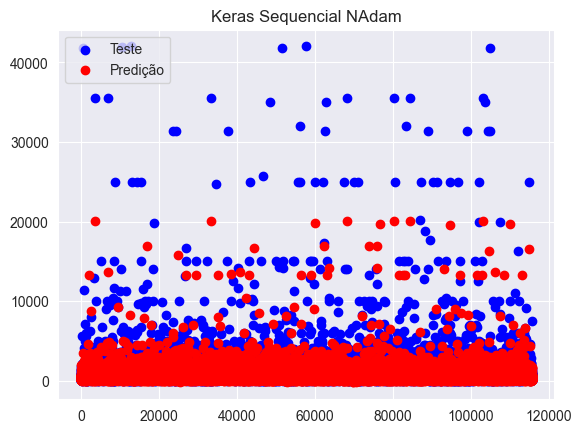

In [86]:
# 5.1 Grafico scatter de valores reais x valores predict
def plotGraph(y_test, y_pred, name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.legend(['Teste', 'Predição'], loc='upper left')
    plt.title(name)
    plt.show()
    return

plotGraph(y_test, prediction_data, "Modelo Keras Sequencial NAdam")